## Import's

In [1]:
import pandas as pd
import sqlite3

## Подключение к БД

In [2]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

In [3]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,pageviews
1,checker
2,deadlines


In [4]:
schema = pd.read_sql("PRAGMA table_info(pageviews);", conn)
schema

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,uid,TEXT,0,None,0
2,2,datetime,TIMESTAMP,0,None,0


## Забираем коммиты пользователей

In [5]:
query = '''
SELECT
    uid,
    timestamp
FROM checker
WHERE uid LIKE 'user_%'
'''

df = pd.read_sql(query, conn)

In [6]:
df.head()

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370


## Преобразования даты и выделение выходных

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

df['weekday'] = df['timestamp'].dt.weekday
df['is_weekend'] = df['weekday'] >= 5


In [8]:
df.head()

,uid,timestamp,date,hour,weekday,is_weekend
0,user_4,2020-04-17 05:19:02.744528,2020-04-17,5,4,False
1,user_4,2020-04-17 05:22:35.249331,2020-04-17,5,4,False
2,user_4,2020-04-17 05:22:45.549397,2020-04-17,5,4,False
3,user_4,2020-04-17 05:34:14.691200,2020-04-17,5,4,False
4,user_4,2020-04-17 05:34:24.422370,2020-04-17,5,4,False


## Подсчёт коммитов по часам в выходные

In [9]:
commits_per_hour = df.groupby(['date', 'hour', 'is_weekend']).size().reset_index(name='commits')

commits_per_hour.head()

,date,hour,is_weekend,commits
0,2020-04-17,5,False,13
1,2020-04-17,11,False,8
2,2020-04-17,12,False,2
3,2020-04-18,7,True,1
4,2020-04-18,13,True,5


## Среднее кол-во комитов в час

In [10]:
all_hours = pd.DataFrame({'hour': list(range(24))})

workdays = commits_per_hour[commits_per_hour['is_weekend'] == False]
weekends = commits_per_hour[commits_per_hour['is_weekend'] == True]

workdays_avg = (
    workdays.groupby('hour')['commits']
    .mean()
    .reset_index(name='avg_commits_working')
    .merge(all_hours, on='hour', how='right')
    .fillna(0)
    .sort_values('hour')
)

weekends_avg = (
    weekends.groupby('hour')['commits']
    .mean()
    .reset_index(name='avg_commits_weekend')
    .merge(all_hours, on='hour', how='right')
    .fillna(0)
    .sort_values('hour')
)

avg_commits = pd.merge(workdays_avg, weekends_avg, on='hour')


In [11]:
avg_commits

,hour,avg_commits_working,avg_commits_weekend
0,0,3.000000,2.000000
1,1,0.000000,6.000000
2,2,0.000000,0.000000
3,3,2.000000,1.000000
4,4,0.000000,0.000000
5,5,7.500000,2.000000
6,6,1.500000,0.000000
7,7,5.166667,4.000000
8,8,3.700000,7.000000
9,9,6.000000,3.666667


In [12]:
avg_commits.loc[17]

hour                   17.000000
avg_commits_working    16.000000
avg_commits_weekend     7.142857
Name: 17, dtype: float64

## Построение графика

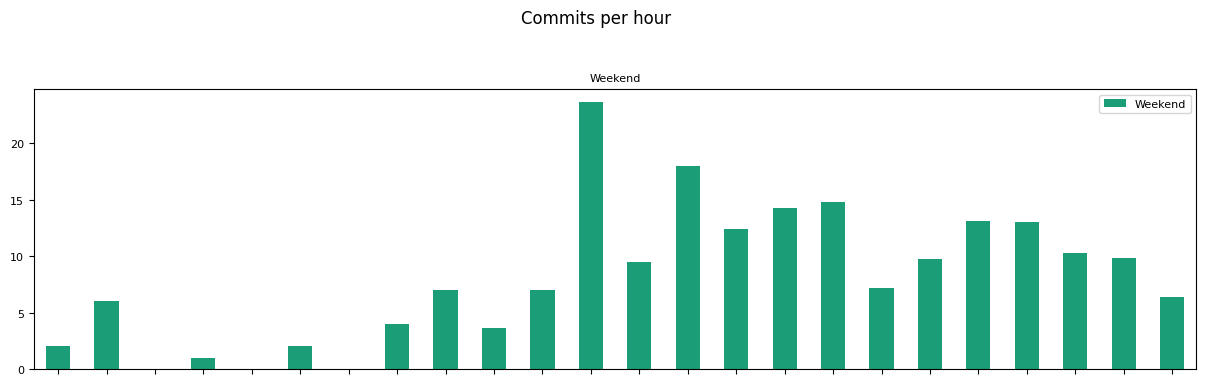

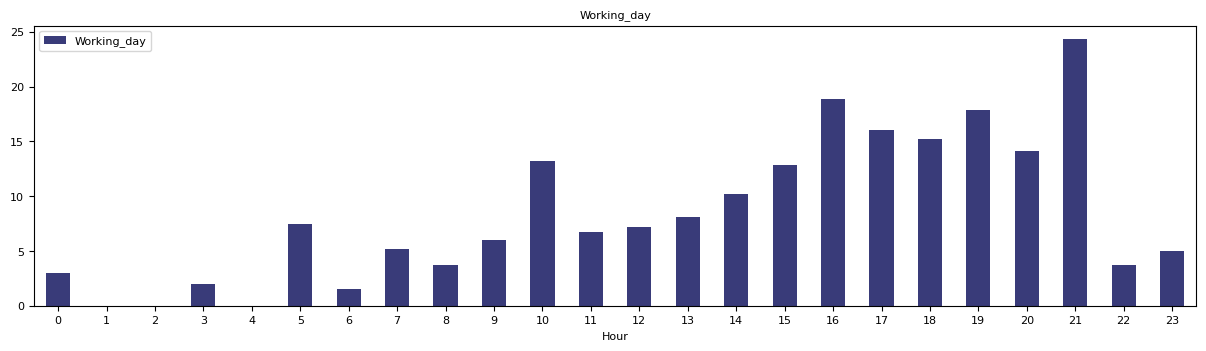

In [13]:
ax1 = avg_commits[['avg_commits_weekend']].plot(
    kind='bar',
    figsize=(15, 8),
    fontsize=8,
    label='weekend',
    title='Commits per hour',
    subplots=True,
    layout=(2, 1),
    sharex=True,
    colormap='Dark2'
)

ax2 = avg_commits[['avg_commits_working']].plot(
    kind='bar',
    figsize=(15, 8),
    fontsize=8,
    label='working_day',
    subplots=True,
    layout=(2, 1),
    sharex=True,
    colormap='tab20b'
)

ax1[0, 0].set_title('Weekend', fontsize=8)
ax1[0, 0].set_xticklabels([])
ax1[0, 0].legend(['Weekend'], fontsize=8)

ax2[0, 0].set_title('Working_day', fontsize=8)
ax2[0, 0].tick_params(axis='x', labelrotation=0, labelsize=8)
ax2[0, 0].set_xlabel('Hour', fontsize=8)
ax2[0, 0].legend(['Working_day'], loc='upper left', fontsize=8)

## Закрываем соединение с БД

In [14]:
conn.close()

## Is the dynamic different on working days and weekends?

Yes, it is different.

The hour with the **largest number of commits during working days** is: **21**

The hour with the **largest number of commits during weekends** is: **11**

In [15]:
max_work_hour = avg_commits.loc[avg_commits['avg_commits_working'].idxmax(), 'hour']
max_week_hour = avg_commits.loc[avg_commits['avg_commits_weekend'].idxmax(), 'hour']

print("Working day peak hour:", max_work_hour)
print("Weekend peak hour:", max_week_hour)

Working day peak hour: 21
Weekend peak hour: 11
